In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-delays/airlines.csv
/kaggle/input/flight-delays/airports.csv
/kaggle/input/flight-delays/flights.csv


In [33]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objs as go
import plotly.offline as py
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [34]:
df = pd.read_csv('../input/flight-delays/flights.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


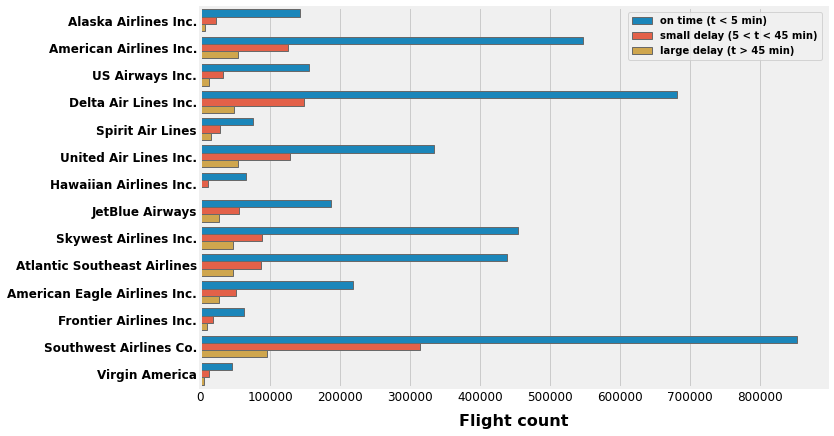

In [35]:
airlines_names = pd.read_csv('../input/flight-delays/airlines.csv')
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [36]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-24.0,644.0,61385.0,9.022595
HA,-27.0,1433.0,76119.0,0.485713
F9,-46.0,1112.0,90290.0,13.350858
NK,-37.0,836.0,115454.0,15.944766
AS,-82.0,963.0,171910.0,1.785801
US,-35.0,759.0,194825.0,6.141137
B6,-31.0,1006.0,262843.0,11.514353
MQ,-36.0,1544.0,280282.0,10.125188
UA,-40.0,1314.0,509534.0,14.435441


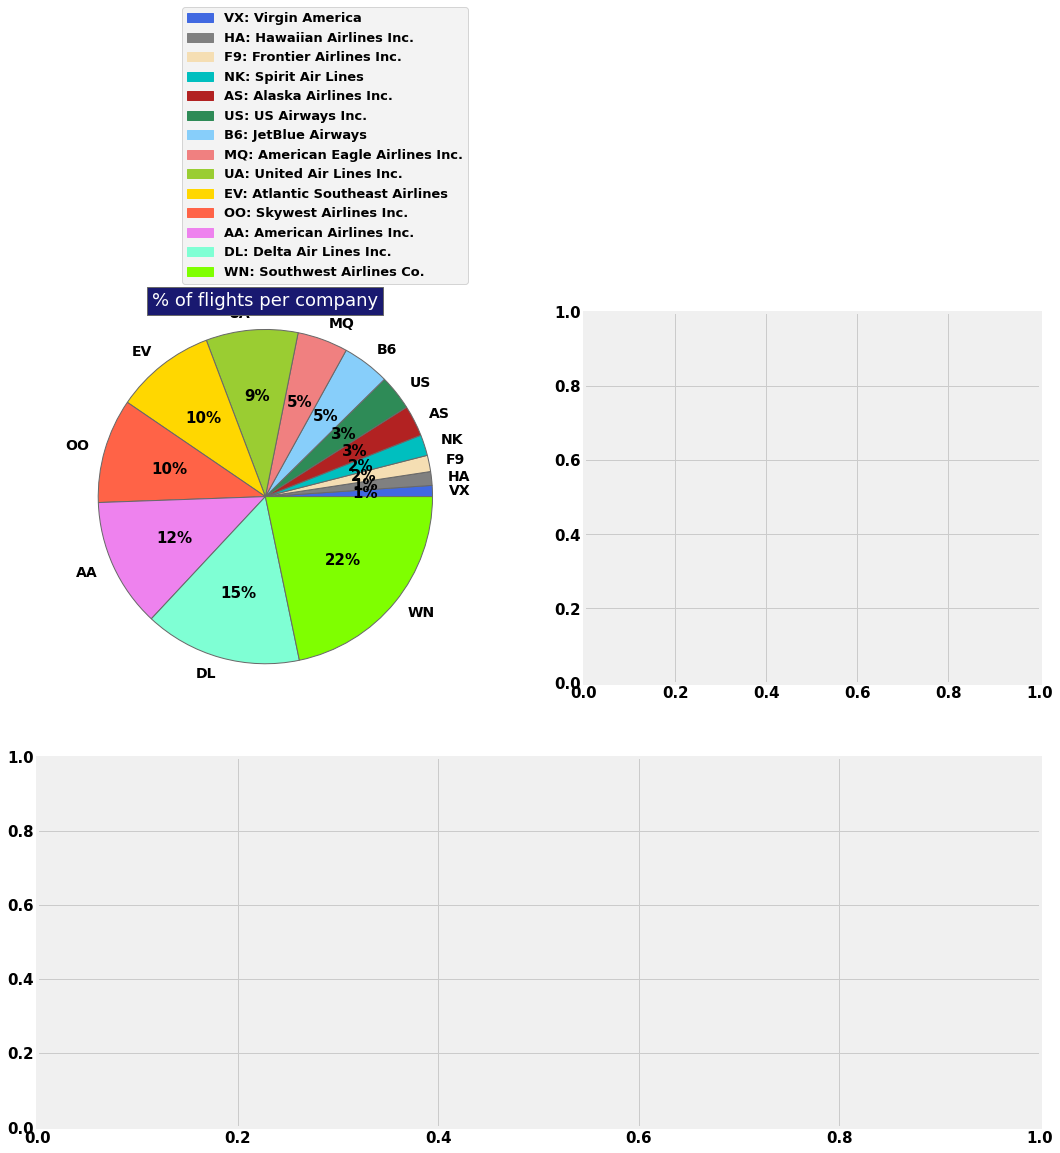

In [37]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
#extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)

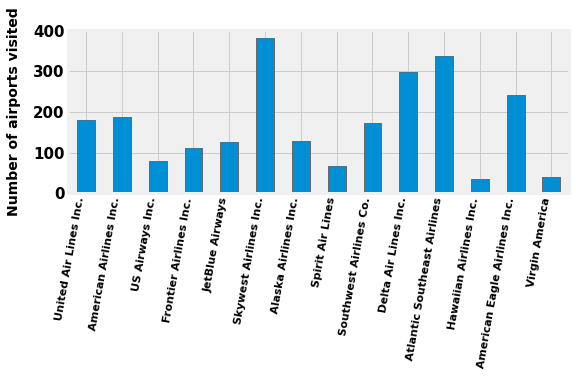

In [38]:
# number of destination airports for each airline
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [39]:
#number of flights per month
F=df.MONTH.value_counts().to_frame().reset_index().sort_values(by='index')
F.columns=['Month','Flight_Values']
Month={1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',6: 'Jun',
       7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
F.Month=F.Month.map(Month)
colors = ['skyblue', '#FEBFB3', '#96D38C', '#D0F9B1','lightblue','lightgreen',
          'aqua','yellow','#D4E157','#D1C4E9','#1A237E','#64B5F6']
trace=go.Bar(x=F.Month,y=F.Flight_Values,marker=dict(color=colors))
data=[trace]
layout = go.Layout(title='Monthly Flights',yaxis=dict(title='Flights Value'),height=500, width=800)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)   

In [40]:
# Count the number of NAN and different values in each column
def count_NA_levels(data):
    for i in data.columns:
        x = data[i].unique()
        y = data[i]
        count_na = data.shape[0] - (y.dropna(axis=0, how='any')).shape[0]
        if count_na > 0:
            print(i + '({} NaN): '.format(count_na) + str(len(x)))
        else:
            print(i + '(no NaN): ' + str(len(x)))
flight_dropna = df.dropna(axis=0, how='any', subset=['ARRIVAL_DELAY', 'DEPARTURE_DELAY'])
count_NA_levels(flight_dropna)

YEAR(no NaN): 1
MONTH(no NaN): 12
DAY(no NaN): 31
DAY_OF_WEEK(no NaN): 7
AIRLINE(no NaN): 14
FLIGHT_NUMBER(no NaN): 6946
TAIL_NUMBER(no NaN): 4896
ORIGIN_AIRPORT(no NaN): 628
DESTINATION_AIRPORT(no NaN): 629
SCHEDULED_DEPARTURE(no NaN): 1320
DEPARTURE_TIME(no NaN): 1440
DEPARTURE_DELAY(no NaN): 1212
TAXI_OUT(no NaN): 184
WHEELS_OFF(no NaN): 1440
SCHEDULED_TIME(no NaN): 549
ELAPSED_TIME(no NaN): 712
AIR_TIME(no NaN): 675
DISTANCE(no NaN): 1350
WHEELS_ON(no NaN): 1440
TAXI_IN(no NaN): 184
SCHEDULED_ARRIVAL(no NaN): 1434
ARRIVAL_TIME(no NaN): 1440
ARRIVAL_DELAY(no NaN): 1240
DIVERTED(no NaN): 1
CANCELLED(no NaN): 1
CANCELLATION_REASON(5714008 NaN): 1
AIR_SYSTEM_DELAY(4650569 NaN): 571
SECURITY_DELAY(4650569 NaN): 155
AIRLINE_DELAY(4650569 NaN): 1068
LATE_AIRCRAFT_DELAY(4650569 NaN): 696
WEATHER_DELAY(4650569 NaN): 633
DELAY_LEVEL(no NaN): 3


In [41]:
flight_clean = flight_dropna.loc[:,['MONTH','DAY','DAY_OF_WEEK',
                           'AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT',
                           'DEPARTURE_DELAY','ARRIVAL_DELAY', 'DISTANCE',
                           'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                           'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'
                          ]]
delay_over15min = flight_clean.dropna(subset=['AIR_SYSTEM_DELAY','SECURITY_DELAY',
                                        'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY',
                                        'WEATHER_DELAY'], how='all')
flight = flight_clean.drop(['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                           'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'], axis=1)

In [42]:
# merge the fullname of airline companies into flight data
flight_fullname = flight.rename(columns={'AIRLINE': 'IATA_CODE'})
flight_fullname = flight_fullname.merge(airlines_names, on='IATA_CODE')

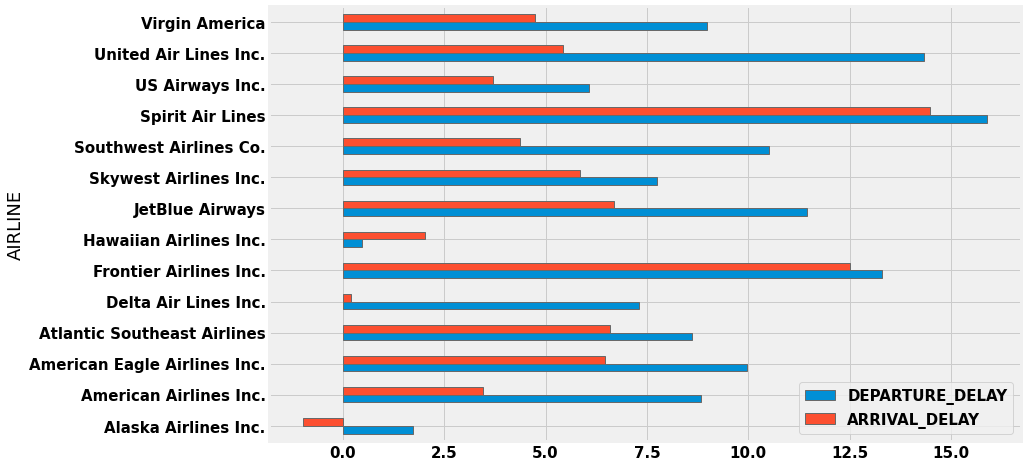

In [43]:
# Make clear on DEPARTURE_DELAY and ARRIVAL_DELAY
# Delay caused before departure or after departure?

airline_deparr_plot = flight_fullname.loc[:, ['AIRLINE', 
                                     'DEPARTURE_DELAY',
                                     'ARRIVAL_DELAY']].groupby('AIRLINE').mean()
airline_deparr_plot
airline_deparr_plot.plot.barh(figsize=(12,8), stacked=False)
plt.show()

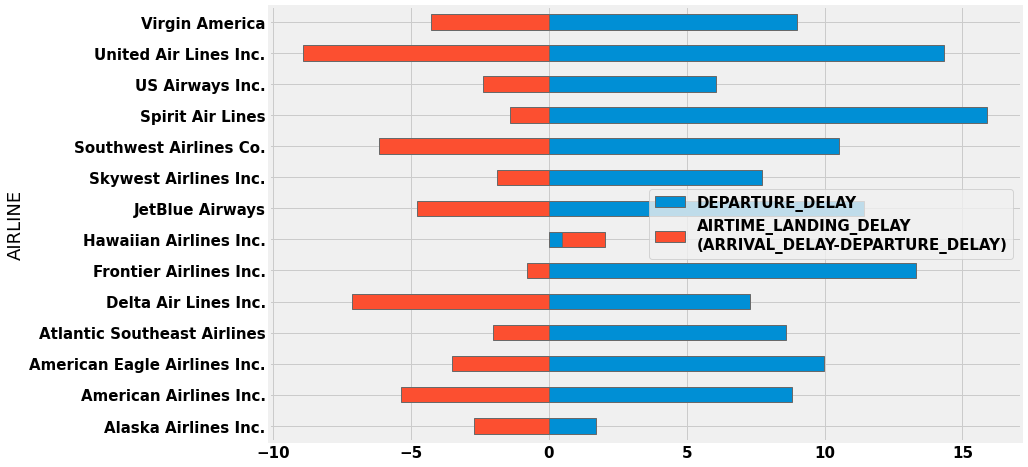

In [44]:
# ARRIVAL_DELAY is the total delay, i.e. delay result of this flight
# extract the delay in the airtime and landing
airline_deparr_plot['ARRIVAL_DELAY'] = (- airline_deparr_plot['DEPARTURE_DELAY'] 
                                        + airline_deparr_plot['ARRIVAL_DELAY'])
ax = airline_deparr_plot.plot.barh(figsize=(12,8), stacked=True)
ax.legend(['DEPARTURE_DELAY', 'AIRTIME_LANDING_DELAY\n(ARRIVAL_DELAY-DEPARTURE_DELAY)'])
# ax.title('')
plt.show()